## Učitavanje baze, skidanje slikovnog materijala, treniranje i testiranje


In [1]:
from settings import *

# provjera postavki
import torch
print(f"CUDA is available: {torch.cuda.is_available()}.", f"Activated version of CUDA is {torch.version.cuda}.", torch.cuda.device(0))
print(f"Volta's gencode (sm_86) for RTX 3050 and 3070 is in arch_list: {'sm_86' in torch.cuda.get_arch_list()}.")

CUDA is available: True. Activated version of CUDA is 12.1. <torch.cuda.device object at 0x7f3ab497b390>
Volta's gencode (sm_86) for RTX 3050 and 3070 is in arch_list: True.


In [2]:
# from utils.previewer import preview_image_grid
# preview_image_grid(df=pd.read_parquet("./data/wikiart_composed.parquet"), taste="Naturalism" ) # categories["depth"]["iconic"][4]

#### Skidanje slika po kategorijama


In [16]:
from utils.downloader import image_downloader
categories = image_downloader(base=database, categories=categories, sample_size=sample_size, image_size=image_size, skip_downloads=True)


 Neispravnih: 0


#### Priprema DataLoaders-a za modele


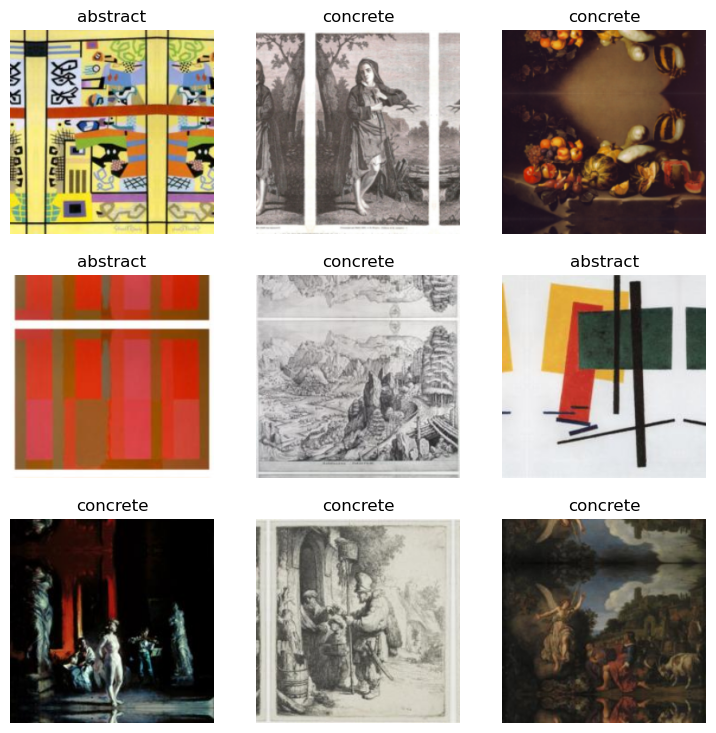

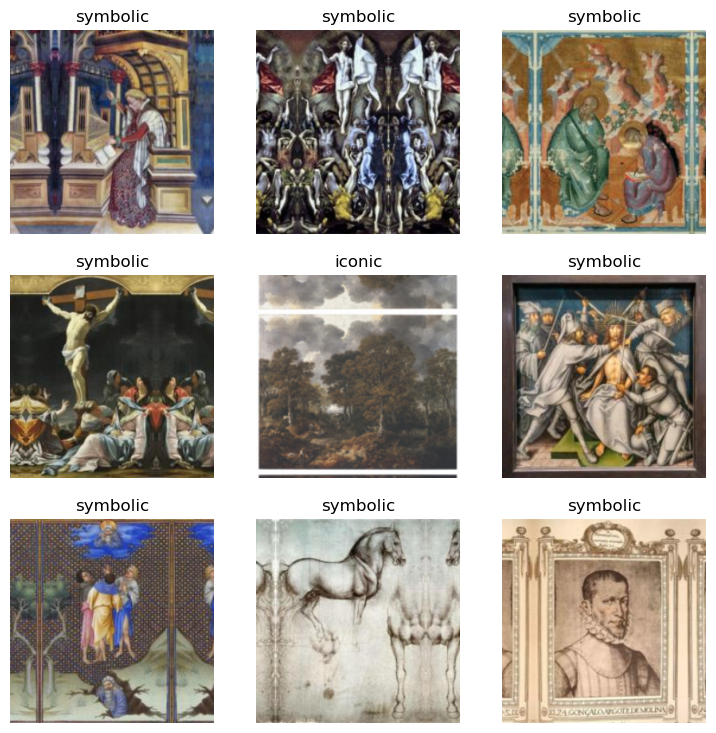

In [2]:
from utils.learners import create_dataloaders
dls = create_dataloaders(container, categories)

#### Izbor i trening modela na podatcima


>>> Preparing breath! >>>
>>> Preparing depth! >>>


Best learning rate for breath 1x is 0.00855698458229502, because thats the μ of SuggestedLRs(minimum=0.014454397559165954, valley=0.00363078061491251, slide=0.007585775572806597).
>>> Training breath 1x! >>>


>>> Training depth 1x! >>>


>>> Preparing breath! >>>
>>> Preparing depth! >>>


Best learning rate for breath 3x is 0.012607148778624832, because thats the μ of SuggestedLRs(minimum=0.025118863582611083, valley=0.001737800776027143, slide=0.010964781977236271).
>>> Training breath 3x! >>>


>>> Training depth 3x! >>>


>>> Preparing breath! >>>
>>> Preparing depth! >>>


Best learning rate for breath 10x is 0.012054941663518547, because thats the μ of SuggestedLRs(minimum=0.02089296132326126, valley=0.0020892962347716093, slide=0.013182567432522774).
>>> Training breath 10x! >>>


>>> Training depth 10x! >>>


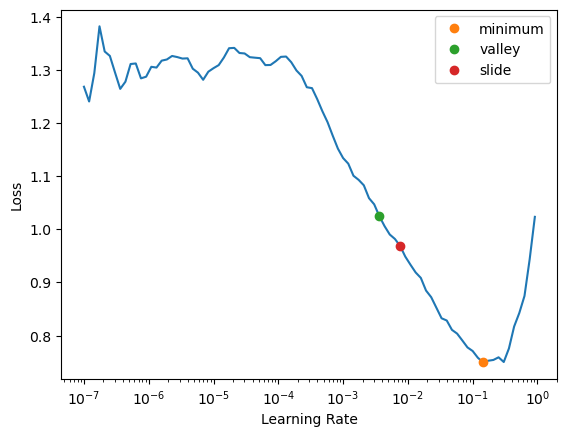

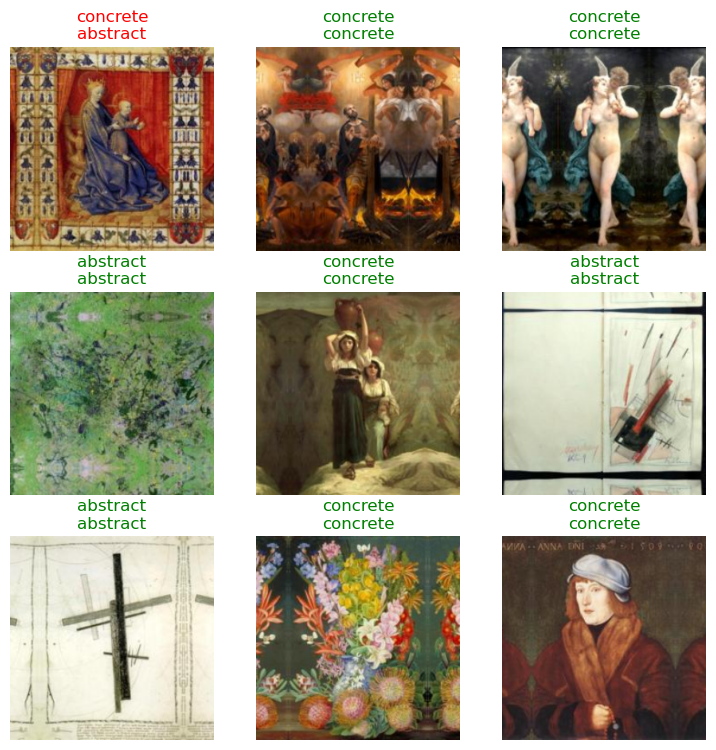

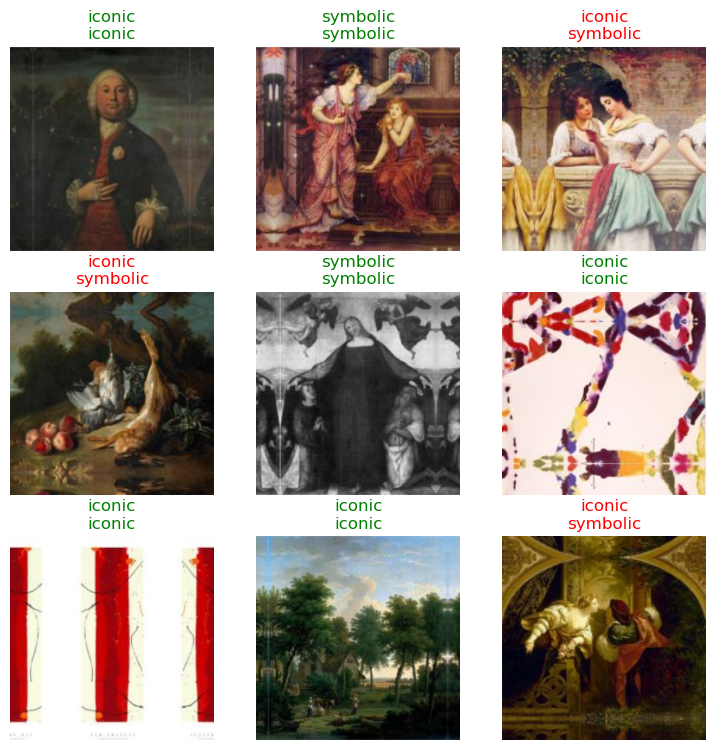

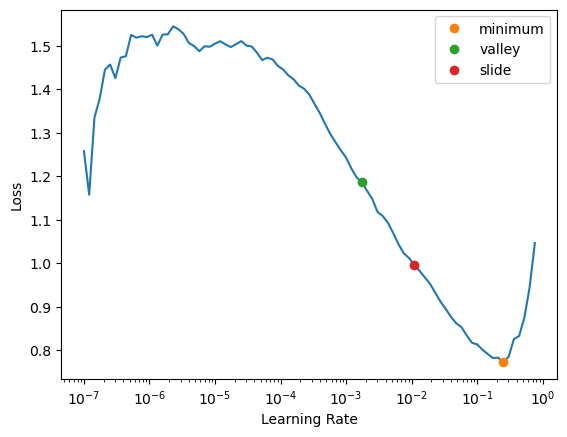

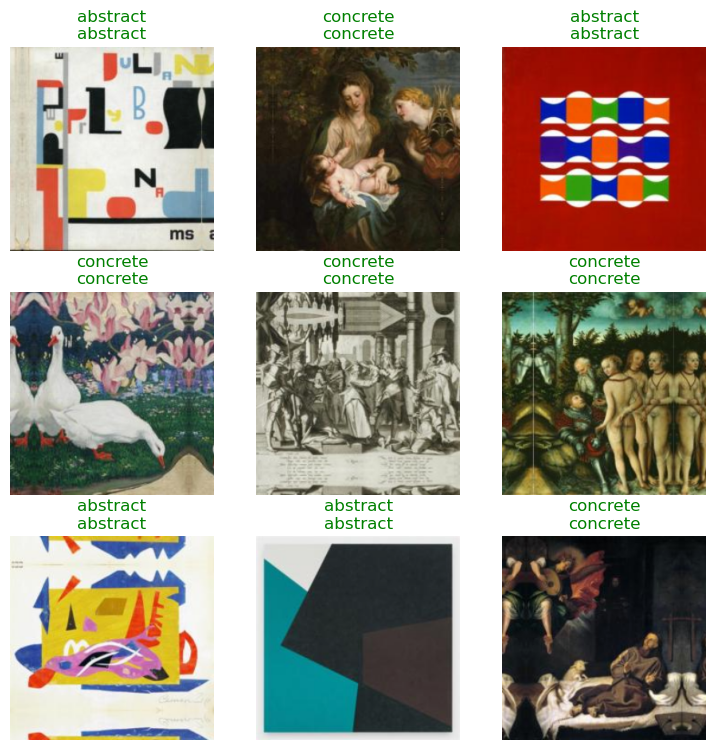

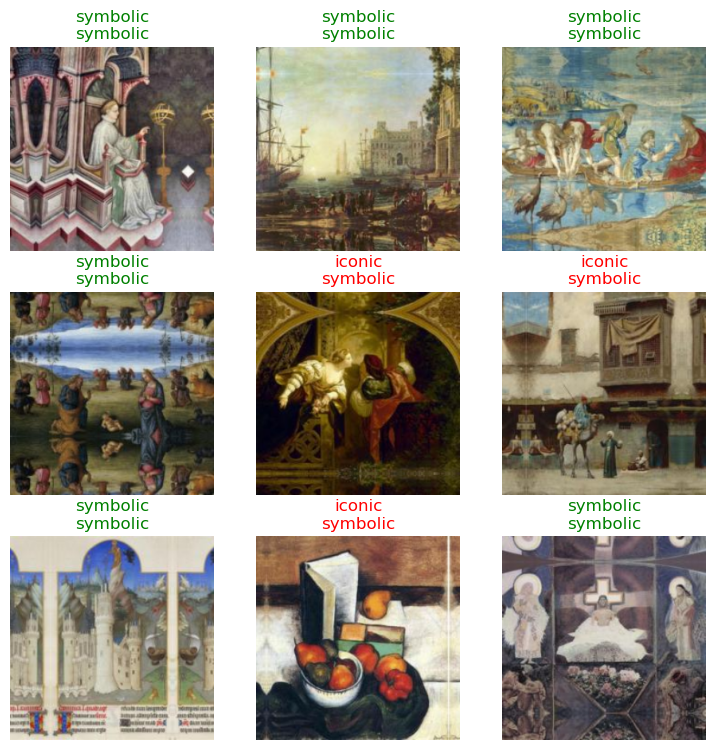

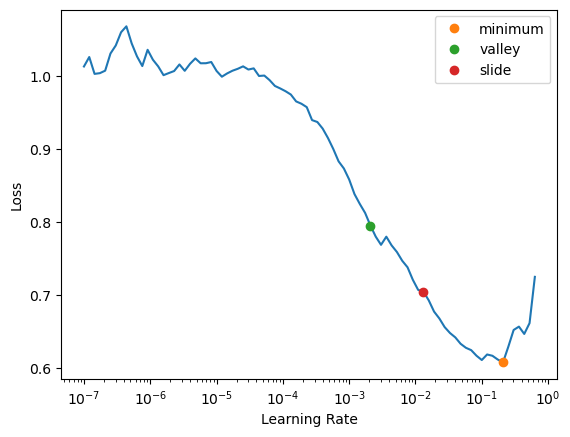

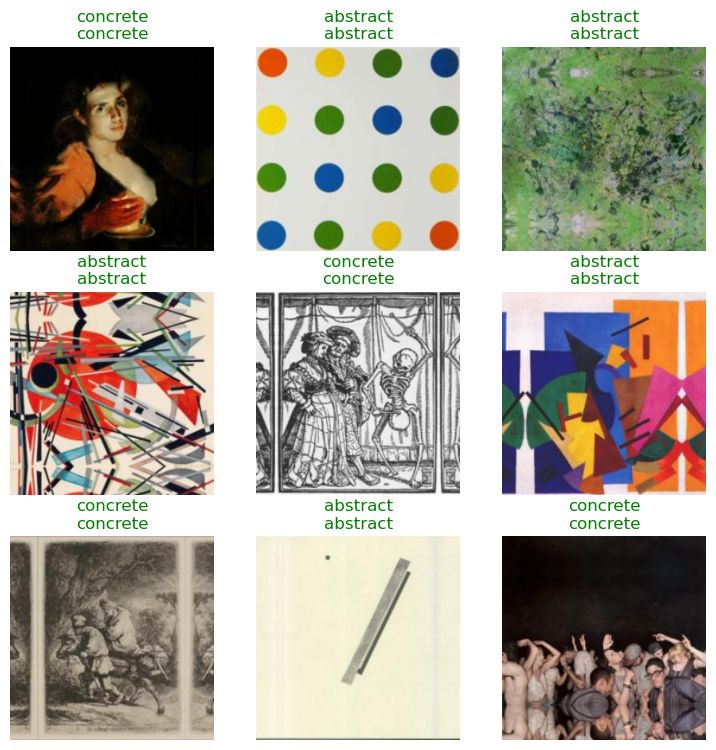

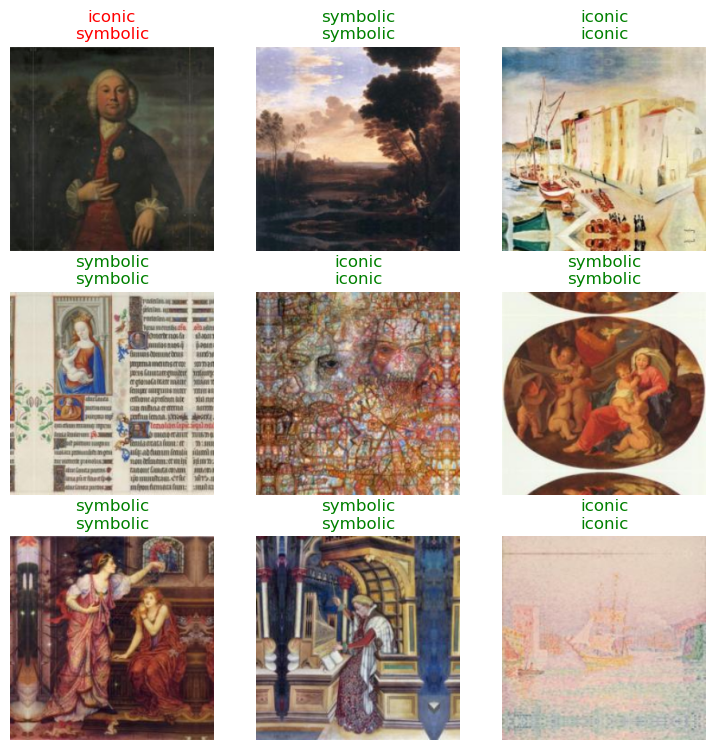

In [3]:
from fastai.vision import models
from utils.learners import create_learners, train_learners

model_picks = ["alexnet"]
learners = {}

for iteration_count in iteration_counts:
    for model_pick in model_picks:
        if model_pick.__contains__("xresnet"):
            model = getattr(models.xresnet, model_pick )    
        elif model_pick.__contains__("unet"):
            model = getattr(models.unet, model_pick ) 
        elif model_pick.__contains__("tvm"):
            model = getattr(models.tvm, model_pick ) 
        else:
            model = getattr(models, model_pick ) 

        learners[f"{model_pick}_{iteration_count}x"] = create_learners(dls, model=model)

        train_learners(learners[f"{model_pick}_{iteration_count}x"], model_pick, iters=iteration_count, lr=None, show_results=True, export=True)


breath <fastai.learner.Learner object at 0x7f3a907f0b10>
[[0.13290715217590332, 0.03125]]
depth <fastai.learner.Learner object at 0x7f3a90407990>
[[0.33722934126853943, 0.171875]]
breath <fastai.learner.Learner object at 0x7f3a97cd7910>
[[0.2685581147670746, 0.078125]]
depth <fastai.learner.Learner object at 0x7f3a907274d0>
[[0.37627333402633667, 0.171875]]
breath <fastai.learner.Learner object at 0x7f3a6e6afd10>
[[0.27852004766464233, 0.03125]]
depth <fastai.learner.Learner object at 0x7f3a6e76ba10>
[[0.4231790602207184, 0.109375]]


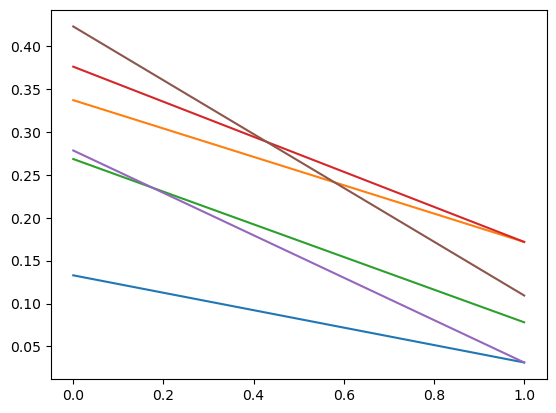

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from fastcore.utils import L 

for name, learner in learners.items():
    for dimension, model in learner.items():
        print(dimension, model)
        # model.recorder.plot_loses(title=f"{name}_{dimension}")
        print(model.recorder.values)
        plt.plot(model.recorder.values[0])

In [27]:
from fastai.vision.widgets import ImageClassifierCleaner
import os


cleaners = {}
model_picks = next(os.walk("./models"))[1]
examplar = model_picks[2]

for dimension, learner in learners[examplar].items():
    # print(dimension, learner)
    cleaners[dimension] = ImageClassifierCleaner(learner)

In [28]:
cleaners["breath"]

In [29]:
cleaners["depth"]

In [9]:
import shutil

for dimension, cleaner in cleaners.items():
    try:
        for idx in cleaner.delete(): cleaner.fns[idx].unlink()
        for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx], container/ dimension / cat))
    except Exception as ex:
        print(ex)

str() argument 'encoding' must be str, not PosixPath
